# Pose Comparison with Body-part-level Pose Distance

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import math
import socket
import time

In [3]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPractice.mp4'


# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 3
    lambdaVal = 1.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(swingDiff_highQual)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Variables for each frame
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
#         norm_vectors_only_body.reshape(2,12,3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)

                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

[0.07518982 0.03076579 0.88722799 0.02535818 0.87746535 0.01053181
 0.10212071 0.14746081 0.00645807 0.10266214 0.00594943 0.07941888]
[0.80042337 0.37269402 0.4564446  0.78371363 0.63385429 0.13177695
 0.01100557 0.87956053 0.17534584 0.00625433 0.10145654 0.00466321]
[0.80243268 0.37542507 0.43000744 0.78556332 0.6168407  0.13162674
 0.01073795 0.87974629 0.17395179 0.00847321 0.09643714 0.00125775]
[0.07894811 0.02675886 0.88706193 0.03059621 0.87776157 0.01191067
 0.10239361 0.13111175 0.01020746 0.1014158  0.00527346 0.20197687]
[0.04837983 0.02279338 0.88560304 0.02190015 0.87723733 0.00939373
 0.08763997 0.12279906 0.00810176 0.10113985 0.00610594 0.25088461]
[0.05346325 0.03141742 0.88526936 0.01635427 0.8767862  0.007398
 0.08758491 0.12076952 0.00707062 0.1017989  0.00536128 0.25160425]
[0.04588006 0.02629008 0.88491142 0.01901369 0.87694061 0.00870838
 0.08773796 0.11174173 0.00702572 0.10312317 0.00565065 0.25080679]
[0.04867673 0.03215287 0.88542055 0.02163804 0.87666634 0

[0.86845893 0.81017406 0.01383257 0.75479728 0.6223888  0.00393286
 0.00488666 0.82956571 0.09422557 0.00298079 0.10015538 0.01930609]
[0.84003988 0.80911368 0.02310993 0.78750951 0.63006643 0.00410547
 0.00478868 0.82158496 0.08409191 0.00490313 0.08733071 0.0228963 ]
[0.81006879 0.81734989 0.00913295 0.77774158 0.64168421 0.00369727
 0.00587346 0.82565731 0.08035037 0.00362665 0.08764127 0.01958393]
[0.74887088 0.83056768 0.01674271 0.77212583 0.64936928 0.05865228
 0.0050086  0.87620578 0.14744192 0.00443068 0.085711   0.01897495]
[0.75074138 0.82733073 0.00931364 0.74902145 0.68080235 0.05549404
 0.00723634 0.87469127 0.1478864  0.00403053 0.08472536 0.01598798]
[0.69736693 0.65016485 0.50981941 0.72835539 0.89220411 0.02810721
 0.00544174 0.8752849  0.14224642 0.00940666 0.08498329 0.01215915]
[0.76852023 0.8276154  0.01135554 0.78779453 0.68759877 0.05155778
 0.00588128 0.88274334 0.13126432 0.00866083 0.08368842 0.01685592]
[0.77309532 0.84258892 0.03931235 0.87115254 0.13042428

In [8]:
### Calculate d

d = []
confidence_level = []


# loop for each body part
for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
    # Calculate confidence_level & build confidence_level array
    confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array
    
    # Calculate Vr (average value of each body part)
    Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)
    
    # Calculate Vj - Vr
    raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row
    
    # Calculate |Vj - Vr| (norm)
    norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)
    
    # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
    tempD = np.sum(norm_Vj_Vr_substract)
    d.append(tempD)

print(d)

### Calculate Body-part-level Pose Distance (BPD)
BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
print(BPD)

[0.1015724233234104, 3.5480096735965247, 3.53583466513402, 3.640168912537869, 3.425394260902789, 3.4893855865078605, 3.5235106020968585, 0.9421679735181471, 3.656239475496192, 3.549964710684423, 3.857586429292925, 3.5812965055916255]
[0.05078621 1.77400484 1.76791733 1.82008446 1.71269713 1.74469279
 1.7617553  0.47108399 1.82811974 1.77498236 1.92879321 1.79064825]


In [26]:
norm_vectors_only_body[:,0,:][1][:2]

array([-0.81517833, -0.57920998])

In [23]:
norm = np.linalg.norm(norm_vectors_only_body[:,0,:][1][:2])
print(norm)

0.9999999610982001


In [12]:
norm_vectors_only_body[:,0,:]

array([[-0.99941862,  0.03409468,  0.90827596],
       [-0.99815601, -0.06069986,  0.92515367]])

In [15]:
norm_vectors_only_body[:,0,:2]

array([[-0.99941862,  0.03409468],
       [-0.99815601, -0.06069986]])

In [14]:
norm_vectors_only_body[:,row,:][:2]

array([[0.08270106, 0.9965744 , 0.82501745],
       [0.08085329, 0.99672598, 0.83367884]])

In [28]:
# Calculate Vr (average value of each body part)
Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]
Vr_avg_row

array([0.08177718, 0.99665019])

In [32]:
norm_vectors_only_body[:,row,:2]

array([[0.08270106, 0.9965744 ],
       [0.08085329, 0.99672598]])

In [33]:
# Calculate Vj - Vr
raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row
raw_Vj_Vr_subtract

array([[ 9.23886895e-04, -7.57873058e-05],
       [-9.23886895e-04,  7.57873058e-05]])

In [34]:
# Calculate |Vj - Vr| (norm)
norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)
norm_Vj_Vr_substract

array([0.00092699, 0.00092699])

In [12]:
# Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
tempD = np.sum(norm_Vj_Vr_substract)
tempD

3.5812965055916255

In [14]:
import numpy as np

# original array
arr = np.array([[-0.99941862, 0.03409468, 0.90827596],
                [-0.99815601, -0.06069986, 0.92515367]])

# take the mean along axis 0 and reshape the result
avg_arr = np.mean(arr, axis=0)[:2]

print(avg_arr)

[-0.99878731 -0.01330259]


In [16]:
import numpy as np

arr = np.array([[1, 1], [2, 2]])
sub_arr = np.array([1, 1])
result = arr - sub_arr

print(result)

[[0 0]
 [1 1]]


In [24]:
sub_arr = np.array([2, 2])
sub_arr / 2

array([1., 1.])

In [25]:
import numpy as np

a = np.array([1.0, 4.0, 9.0])
b = np.power(a, 0.5)

print(b)

[1. 2. 3.]


In [26]:
import numpy as np

vectors = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

average_vector = np.mean(vectors, axis=0)

print(average_vector)  # Output: [4. 5. 6.]

[4. 5. 6.]


In [20]:
import numpy as np

vector = np.array([1, 1])
norm = np.linalg.norm(vector)
print(norm)

1.4142135623730951


In [36]:
a = map_range(2,0,1,0,10)
a

20.0

In [37]:
import numpy as np

# define input value
input_value = 0.5

# define input range
input_min = 0
input_max = 1

# define output range
output_min = 0
output_max = 255

# scale input value to output range
output_value = np.interp(input_value, [input_min, input_max], [output_min, output_max])

print(output_value)  # output: 127.5

127.5


In [41]:
output_value = np.interp(-1, [0, 1], [0, 10])
print(output_value)  # output: 127.5

0.0


# Saving pandas dataframe as CSV & Drawing plots

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
import pandas as pd

In [ ]:
csv_path = '../../data/csv/'
csv_name = 'BPDtest.csv'
with open(csv_path + csv_name, mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [20]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'
actionPractice = video_path + 'actionPractice.mp4'



# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 2
    lambdaVal = 1.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []
    saveBPD = pd.DataFrame(columns=[str(i) for i in range(12)])

    ### Loading Video File
    cap = cv2.VideoCapture(swingDiff_highQual)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Variables for each frame
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(2,12,3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        ### Save each BPD at the saveBPD for CSV saving
        saveBPD = pd.concat([saveBPD, pd.DataFrame([BPD], columns=saveBPD.columns)], ignore_index=True)

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)

                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

[0.05748357 0.04093951 0.00240685 0.0228419  0.04578587 0.00645418
 0.00891952 0.02498386 0.00492521 0.01026921 0.00580498 0.00366288]
[0.05510583 0.03808879 0.00063431 0.02783275 0.04595471 0.00693371
 0.01047883 0.01958756 0.00634552 0.00781332 0.00551349 0.00645576]
[0.05699729 0.03658167 0.00228702 0.02608525 0.04779707 0.00634626
 0.00974388 0.02712214 0.00513976 0.01043722 0.00413006 0.00166056]
[0.05317787 0.03534144 0.00540535 0.02690477 0.04910469 0.00022717
 0.01033071 0.01461014 0.01170817 0.00983403 0.00474386 0.00370701]
[0.05505059 0.03146454 0.00362631 0.02463771 0.04733846 0.00399783
 0.01114733 0.01102219 0.00674925 0.01005473 0.0060029  0.00227793]
[0.05807967 0.04168693 0.00793523 0.01839802 0.05276218 0.00079386
 0.01052365 0.01564517 0.00564648 0.00915902 0.00529096 0.00451389]
[0.04878452 0.03563886 0.02268529 0.02139089 0.05487013 0.00284475
 0.0091227  0.01304753 0.00436712 0.00906758 0.00483098 0.00413742]
[0.05540961 0.04222558 0.01017574 0.02434255 0.05391952

[0.05155038 0.04302041 0.01567054 0.01250937 0.0970628  0.00087955
 0.0080728  0.05046248 0.00832034 0.00272243 0.00602519 0.02447319]
[0.03998739 0.03061293 0.01576797 0.00142939 0.10794627 0.0023168
 0.00569103 0.04116345 0.01047761 0.00286901 0.00409903 0.02171925]
[0.04808535 0.06834453 0.02413867 0.02064619 0.1315336  0.00313274
 0.00302106 0.05863331 0.00740443 0.00423093 0.00353974 0.02355087]
[0.05036292 0.08223146 0.00314633 0.00655588 0.13394936 0.0020012
 0.00278384 0.05640141 0.01693886 0.00387431 0.00016327 0.02001102]
[0.04255666 0.0804391  0.01715776 0.01681802 0.1264979  0.00046608
 0.00111988 0.05539388 0.01764262 0.00553341 0.00836359 0.02053077]
[0.00580004 0.07959224 0.01376572 0.02357495 0.12567068 0.00066991
 0.00834278 0.04375322 0.01086023 0.00539692 0.00783436 0.01883914]
[0.00552377 0.06533553 0.0060851  0.02473452 0.14791422 0.00190918
 0.00506176 0.04732462 0.00876667 0.01079473 0.01004574 0.01367898]
[0.00068394 0.09060794 0.01107093 0.00137005 0.11466816 0

[0.00166166 0.9714011  0.2097842  0.14791125 0.43994635 0.01768949
 0.01279382 0.67944896 0.02565175 0.01357936 0.04636632 0.01742126]
[0.04791908 0.96959135 0.21205497 0.08226481 0.07033323 0.00672191
 0.00365918 0.8486461  0.03681734 0.03020488 0.04100387 0.03254279]
[0.01514227 0.96150477 0.1978343  0.10013221 0.08258387 0.01439091
 0.00408427 0.84039139 0.03065471 0.01952864 0.03632681 0.01899894]
[0.03578848 0.961751   0.14067754 0.18403111 0.08269622 0.00893983
 0.00979467 0.90033751 0.02837096 0.01437736 0.03860439 0.01162752]
[0.04553878 0.96897336 0.13068246 0.06286302 0.04656779 0.02271755
 0.00470599 0.89982328 0.03010015 0.00751311 0.03718979 0.01047555]
[0.01868372 0.96783352 0.10413808 0.00335993 0.51381548 0.00533794
 0.00914801 0.90105233 0.02292977 0.01401986 0.03981567 0.00688655]
[0.00914343 0.97596159 0.0798495  0.01949972 0.03304695 0.02106855
 0.00200948 0.76074576 0.01405602 0.009381   0.04355206 0.00465733]
[2.01020111e-04 9.96098748e-01 6.64269077e-02 9.8019201

[0.04872183 0.21115094 0.88780086 0.81263006 0.66359669 0.02287433
 0.02745027 0.92325767 0.07225319 0.04166229 0.0055292  0.01958758]
[0.01464813 0.20315596 0.56954998 0.21674125 0.27645969 0.03218256
 0.01171954 0.36696026 0.04125592 0.00723219 0.00593534 0.01537754]
[0.0295667  0.15788799 0.07119825 0.1955369  0.03691034 0.01485853
 0.00221871 0.18421443 0.04206645 0.00953043 0.01062425 0.02183663]
[0.05068894 0.15714085 0.60092826 0.99619781 0.05019678 0.00251677
 0.00135572 0.20922052 0.0540999  0.00572755 0.02300208 0.02129782]
[0.0759048  0.11022726 0.05471137 0.16211579 0.01247608 0.00181767
 0.00425556 0.00756608 0.04145946 0.00879287 0.02776518 0.02061789]
[0.1114541  0.08527883 0.75504533 0.17078879 0.27498729 0.00544791
 0.00608064 0.91766508 0.05694202 0.01187125 0.03828178 0.02568134]
[0.08669973 0.06370074 0.07982013 0.15428887 0.00448093 0.02254045
 0.00323298 0.20467164 0.02929023 0.00125062 0.01505116 0.02537814]
[0.07264168 0.07162529 0.08655608 0.12700367 0.20342745

[0.09757835 0.10068144 0.02793215 0.87732999 0.17321212 0.00938951
 0.00332251 0.05882371 0.01425463 0.00538787 0.0113261  0.00155425]
[0.27305671 0.04231871 0.02442902 0.02159768 0.2502057  0.00502249
 0.00939478 0.01387775 0.01571496 0.00740036 0.02027579 0.01847904]
[0.25796511 0.04872545 0.04665728 0.12833821 0.38322205 0.00630928
 0.01174352 0.00911405 0.02025096 0.0116161  0.01861501 0.00628954]
[0.18233184 0.01513158 0.99642829 0.04087382 0.09791796 0.0113438
 0.0069339  0.06206205 0.01428999 0.01132453 0.01797453 0.00214564]
[0.03732134 0.99650517 0.99986948 0.92049577 0.73031795 0.0107029
 0.01041373 0.05706405 0.02489092 0.02426051 0.00711811 0.01248873]
[0.21999442 0.99872279 0.99810014 0.95074209 0.49362439 0.01483905
 0.0064584  0.16425583 0.02404454 0.0170967  0.00985961 0.002453  ]
[0.87619072 0.05637118 0.08155562 0.99798994 0.9995136  0.04184554
 0.01847014 0.04173869 0.00466012 0.01346057 0.01269759 0.01556526]
[0.09715183 0.01914459 0.02596695 0.06532784 0.09427175 0

[0.0302434  0.01071478 0.06649536 0.09581368 0.0378317  0.00286339
 0.00523895 0.0552898  0.00670887 0.0112632  0.01444021 0.01277101]
[0.01222919 0.01019814 0.03271512 0.01394006 0.01631768 0.00370281
 0.00098703 0.05691248 0.00958996 0.0068758  0.03687356 0.01151371]
[0.00850336 0.03359678 0.06033021 0.01266797 0.00741511 0.00111817
 0.00251923 0.05375864 0.00091566 0.00072755 0.03068964 0.00707695]
[0.02159352 0.02743198 0.0560494  0.00551102 0.02056401 0.0052142
 0.00520077 0.05281976 0.00907177 0.00229945 0.03508648 0.01494035]
[0.00782578 0.01572396 0.0147344  0.03088278 0.01245835 0.01286125
 0.00527964 0.09954899 0.01148927 0.00639183 0.03181102 0.0071364 ]
[0.05576702 0.00330875 0.00429569 0.01193275 0.01820638 0.02166319
 0.00689144 0.08089807 0.01459912 0.00280375 0.03731744 0.00513202]
[7.69587039e-02 2.71010736e-02 7.00232037e-04 8.57612938e-03
 9.14384722e-01 2.00875194e-02 6.89737202e-03 5.12660284e-02
 2.24614948e-02 4.61291159e-03 3.15467782e-02 1.04653487e-02]
[0.0397

[0.0425215  0.02809388 0.03500505 0.92239446 0.01136783 0.00095462
 0.01972426 0.00269213 0.0021807  0.03139208 0.02620872 0.03091052]
[0.02251753 0.04941072 0.06352418 0.9045034  0.00095335 0.0055368
 0.0142543  0.01385251 0.00879446 0.02156526 0.02490117 0.03760654]
[2.86161859e-03 1.89085287e-02 5.05428512e-02 9.31899883e-01
 7.87624029e-03 3.72659190e-03 7.77856375e-04 7.79494271e-03
 1.11484301e-02 1.82369818e-02 2.67134084e-02 3.54965018e-02]
[0.00751161 0.01246854 0.06545355 0.0554811  0.01213206 0.00976952
 0.00030217 0.05181691 0.01210667 0.0154526  0.02844877 0.03367   ]
[0.02316102 0.00536022 0.04968541 0.04433655 0.04148731 0.00774363
 0.00919329 0.05617195 0.01316382 0.01002214 0.03000966 0.02676704]
[3.39176135e-02 4.27855195e-03 4.05081630e-02 9.99966866e-01
 3.92573590e-02 8.16864211e-04 7.84011000e-03 5.17310455e-02
 2.14497410e-02 8.92589557e-03 3.62919393e-02 2.63216843e-02]
[2.97811406e-02 1.81947962e-03 5.81812916e-02 5.10593327e-02
 3.27086924e-02 1.34409129e-05 2

[0.02125675 0.07441187 0.01187431 0.02683676 0.06030163 0.01154374
 0.00786873 0.00976318 0.04074965 0.00440439 0.04940426 0.00249013]
[0.01463564 0.0969494  0.00151599 0.0180364  0.0652404  0.01357586
 0.00251535 0.0068291  0.03882939 0.00187205 0.05320511 0.00289598]
[0.01355551 0.10555427 0.01136106 0.02286593 0.05595647 0.0171043
 0.00659825 0.00934694 0.03705939 0.00748756 0.05412602 0.00613313]
[0.02116336 0.12205885 0.05239265 0.01039284 0.05082364 0.02206784
 0.00506369 0.012999   0.03461169 0.01088643 0.0549363  0.00516608]
[0.02523786 0.1258359  0.05830947 0.01060381 0.04574368 0.02126075
 0.00711909 0.00577234 0.03142393 0.01228488 0.05725759 0.00601031]
[0.02682533 0.10885287 0.05967684 0.00346099 0.03103876 0.01922515
 0.00529508 0.00400587 0.03039935 0.01232199 0.05557833 0.00799856]
[0.03604593 0.09019284 0.0576425  0.01441737 0.03166303 0.01641315
 0.00692274 0.00216667 0.02871125 0.01133617 0.05427603 0.01257922]
[0.02646892 0.13077291 0.07777261 0.02456031 0.03345507 

AttributeError: 'NoneType' object has no attribute 'copy'

In [76]:
saveBPD.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
398,0.001825,0.085201,0.062812,0.001152,0.026334,0.013211,0.006735,0.009880,0.030697,0.021290,0.038778,0.010367
399,0.011731,0.072112,0.066028,0.002478,0.024671,0.010980,0.005737,0.014490,0.030099,0.019873,0.036842,0.015144
400,0.002085,0.078379,0.058830,0.003710,0.026824,0.014088,0.006257,0.013880,0.032507,0.020197,0.033237,0.012531
401,0.005859,0.082239,0.057450,0.004566,0.019716,0.014360,0.005801,0.021050,0.030116,0.019272,0.035362,0.016685
402,0.006393,0.084273,0.063833,0.000105,0.030327,0.014903,0.004517,0.014639,0.028409,0.018453,0.036852,0.015884


In [4]:
# Save the csv from the dataframe(saveBPD)
saveBPD.to_csv('../../data/csv/BPDtest_actionPractice.csv', index=False)

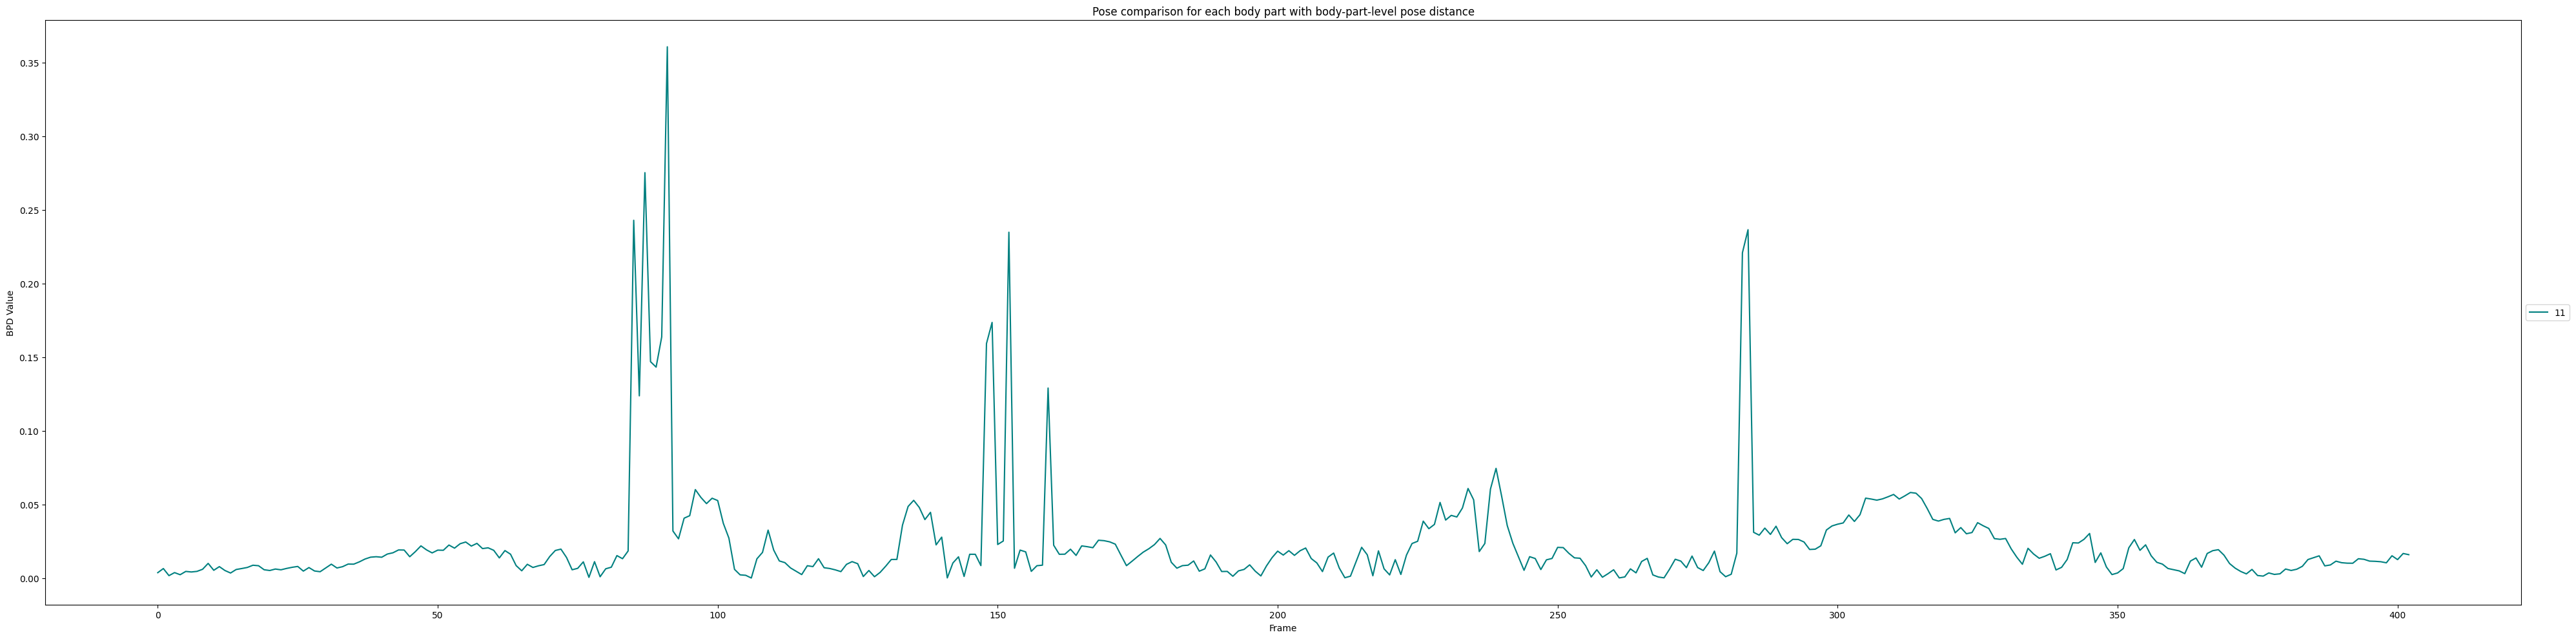

In [33]:
# Draw plot
import pandas as pd
import matplotlib.pyplot as plt

# create a sample dataframe
# data = pd.DataFrame({'col1': [1, 2, 3, 4, 5], 'col2': [2, 4, 6, 8, 10], 'col3': [3, 6, 9, 12, 15], 
#                      'col4': [4, 8, 12, 16, 20], 'col5': [5, 10, 15, 20, 25], 'col6': [6, 12, 18, 24, 30],
#                      'col7': [7, 14, 21, 28, 35], 'col8': [8, 16, 24, 32, 40], 'col9': [9, 18, 27, 36, 45], 
#                      'col10': [10, 20, 30, 40, 50], 'col11': [11, 22, 33, 44, 55], 'col12': [12, 24, 36, 48, 60]})

# plot the lines with different colors
plt.figure(figsize=(40,10))
plt.plot(saveBPD.index, saveBPD['0'], color='red', label='0')
plt.plot(saveBPD.index, saveBPD['1'], color='blue', label='1')
plt.plot(saveBPD.index, saveBPD['2'], color='green', label='2')
plt.plot(saveBPD.index, saveBPD['3'], color='purple', label='3')
plt.plot(saveBPD.index, saveBPD['4'], color='orange', label='4')
plt.plot(saveBPD.index, saveBPD['5'], color='grey', label='5')
plt.plot(saveBPD.index, saveBPD['6'], color='brown', label='6')
plt.plot(saveBPD.index, saveBPD['7'], color='pink', label='7')
plt.plot(saveBPD.index, saveBPD['8'], color='black', label='8')
plt.plot(saveBPD.index, saveBPD['9'], color='olive', label='9')
plt.plot(saveBPD.index, saveBPD['10'], color='navy', label='10')
plt.plot(saveBPD.index, saveBPD['11'], color='teal', label='11')

# set the title, x-axis label, y-axis label and legend
plt.title('Pose comparison for each body part with body-part-level pose distance')
plt.xlabel('Frame')
plt.ylabel('BPD Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save as pdf file
plt.tight_layout()
plt.savefig("BPDtest_swingTwo_.pdf")    # CHANGE THE FILE NAME!!!

# display the plot
plt.show()

In [64]:
data

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12
0,1,2,3,4,5,6,7,8,9,10,11,12
1,2,4,6,8,10,12,14,16,18,20,22,24
2,3,6,9,12,15,18,21,24,27,30,33,36
3,4,8,12,16,20,24,28,32,36,40,44,48
4,5,10,15,20,25,30,35,40,45,50,55,60


In [67]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.array([7, 8, 9])

saveBPD = np.array([])
saveBPD = np.append(saveBPD, a)
saveBPD

array([1., 2., 3.])

In [68]:
saveBPD = np.append(saveBPD, b)
saveBPD

array([1., 2., 3., 4., 5., 6.])

In [69]:
import pandas as pd
import numpy as np

# create an empty dataframe with the desired columns
df = pd.DataFrame(columns=['column_1', 'column_2', 'column_3'])

# loop to generate numpy arrays and append to the dataframe
for i in range(10):
    arr = np.random.rand(3)
    df = pd.concat([df, pd.DataFrame([arr], columns=df.columns)], ignore_index=True)

print(df)

   column_1  column_2  column_3
0  0.443061  0.310702  0.425159
1  0.809646  0.980979  0.312146
2  0.001951  0.830011  0.860644
3  0.199940  0.530914  0.121802
4  0.869159  0.615085  0.893276
5  0.485589  0.694791  0.437492
6  0.832801  0.254332  0.608751
7  0.086024  0.623217  0.902156
8  0.015526  0.682199  0.103819
9  0.649636  0.973024  0.737212


In [70]:
df

,column_1,column_2,column_3
0,0.443061,0.310702,0.425159
1,0.809646,0.980979,0.312146
2,0.001951,0.830011,0.860644
3,0.199940,0.530914,0.121802
4,0.869159,0.615085,0.893276
5,0.485589,0.694791,0.437492
6,0.832801,0.254332,0.608751
7,0.086024,0.623217,0.902156
8,0.015526,0.682199,0.103819
9,0.649636,0.973024,0.737212


In [72]:
df = pd.DataFrame(columns=[str(i) for i in range(12)])
df

,0,1,2,3,4,5,6,7,8,9,10,11
